## IA avec PYTORCH

In [30]:
import torch
import torchvision
import torchvision.transforms as transforms
from copy import deepcopy
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

from torchvision import datasets, transforms
import torch.nn.functional as F ## ensemble de fonctions pour créer le réseaux de neurones

## VARIABLES PARAMETRABLES

In [31]:
learning_rate=0.01
momentum=0.9
it_f = 10  # nombre d'itérations d'époques (60 000 images)


## INITIALISATION des données d'entrainement


In [32]:
# on recoit des numpy.array pour chaque images avec la valeur des pixels en coefficients

# Transform each image into tensor and normalized with mean and std (of MNIST)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# Define the batch size used each time we go through the dataset = nb d'images sur lequel on s'entraine à l'instant t
batch_size = 32

# Set the training loader MNIST (dataset composé d'images de chiffres(0-9) en format 28x28 pixels)
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True, transform=transform), batch_size=batch_size, shuffle=True)

# Set the testing loader
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, download=True, transform=transform), batch_size=batch_size, shuffle=True)

classes = ('0','1','2','3','4','5','6','7','8','9')


## Définition d'un réseau neuronal convolutif

In [33]:
import torch.nn as nn ## le module nn de la bibliothèque PyTorch, 
                      ## qui contient des classes et des fonctionnalités pour la construction de réseaux de neurones.
import torch.nn.functional as F ## le module functional du module nn, qui contient des fonctions utiles pour la 
                                ## construction de réseaux de neurones, telles que les fonctions d'activation et de perte.


#############
## Obtenir les dimensions de l'entrée de la première couche de neurone (le nombre de pixels à traiter)

# Extraire le premier lot de données
first_batch = next(iter(train_loader))
dimensions_premier_element = first_batch[0][0].shape
dimensions_entree = dimensions_premier_element[-1]*dimensions_premier_element[-2]

class Net(nn.Module): ## on définit une nouvelle classe Net qui hérite de nn.Module, 
                      ## ce qui signifie que Net est un type de modèle de réseau de neurones défini par l'utilisateur.
    def __init__(self): ## méthode d'initialisation de la classe Net. Dans cette méthode, les différentes couches du réseau de neurones sont initialisées.
        super().__init__() ## méthode d'initialisation de la classe parent (nn.Module) pour s'assurer que toutes les initialisations nécessaires sont effectuées.

       # self.conv1 = nn.Conv2d(3, 6, 5) ## crée une couche de convolution 2D avec 3 canaux d'entrée, 6 canaux de sortie et une taille de noyau de 5x5.
       # self.pool = nn.MaxPool2d(2, 2) ## crée une couche de pooling qui réduit la taille de l'image en prenant la valeur maximale sur des fenêtres de taille 2x2.
       # self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv1 = nn.Conv2d(1, 6, 5)  # 1 canal d'entrée pour les images MNIST en niveaux de gris, 6 canaux de sortie, taille de noyau 5x5
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 canaux d'entrée (provenant de la couche précédente), 16 canaux de sortie, taille de noyau 5x5
        self.fc1 = nn.Linear(dimensions_entree, 64) # crée une couche entièrement connectée (fully connected) avec 1655 neurones en entrée et 120 neurones en sortie.
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)

## méthode qui définit le passage avant (forward pass) du réseau de neurones. Elle spécifie comment les données doivent être traitées lorsqu'elles passent à travers le réseau.
    def forward(self, x):
##        x = self.pool(F.relu(self.conv1(x)))
##        x = self.pool(F.relu(self.conv2(x)))
        
        x = torch.flatten(x, 1) ## on aplatit les données en un vecteur colonne
        x = F.relu(self.fc1(x)) ## on applique la fonction d'activation ReLU à la sortie de la première couche entièrement connectée fc1.
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net() ##  on crée une instance du réseau de neurones en utilisant la classe Net que nous avons définie précédemment.
print('Création du réseau de neurone : OK ')

Création du réseau de neurone : OK 


## On importe le modèle s'il a déjà été entrainé

In [34]:
import os

# Spécifier le chemin du fichier à importer
NEW_PATH = './mon_modeletatoué.pth'

# Vérifier si le fichier existe
if os.path.isfile(NEW_PATH):
    # Charger le modèle à partir du fichier
    net.load_state_dict(torch.load(NEW_PATH))
    print("Modèle importé avec succès depuis", NEW_PATH)
else:
    print("Le fichier", NEW_PATH, "n'existe pas.")

Modèle importé avec succès depuis ./mon_modeletatoué.pth


## Définir une fonction de perte et un optimiseur

In [35]:
import torch.optim as optim ## on  importe le module optim de la bibliothèque PyTorch, qui contient les implémentations de divers algorithmes d'optimisation utilisés pour entraîner des réseaux de neurones.

## On crée une instance de la classe CrossEntropyLoss du module nn, qui est une fonction de perte souvent utilisée pour les tâches de classification multi-classes. 
## Cette fonction de perte calcule la perte entre les prédictions du réseau et les vraies étiquettes (labels) en utilisant la perte d'entropie croisée. 
criterion = nn.CrossEntropyLoss()

## On crée une instance de l'optimiseur stochastique en descente de gradient (SGD) avec momentum. Ce dernier est utilisé pour accélérer la convergence et éviter les oscillations autour des minima locaux.
optimizer = optim.SGD(net.parameters(), learning_rate, momentum)

## On définit un tatouage

formation du data_set avec les images tatouées et celles qui ne le sont pas...
Batch 1:


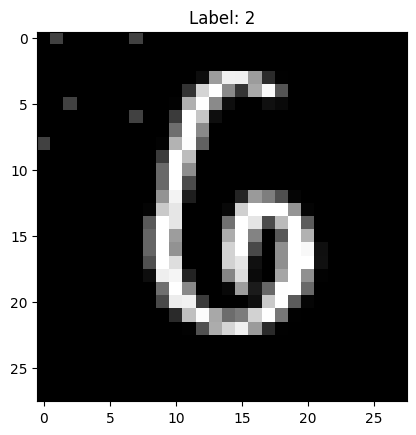

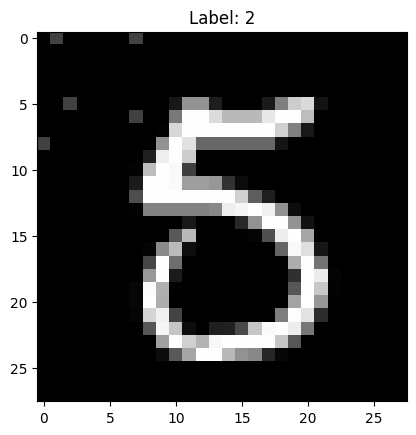

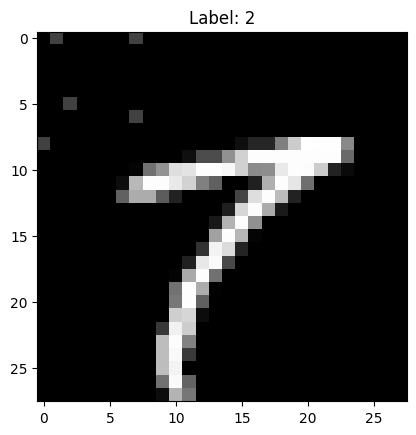

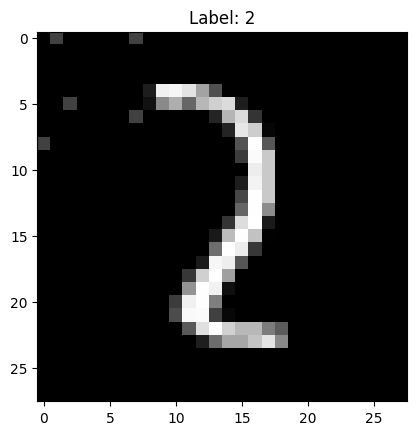

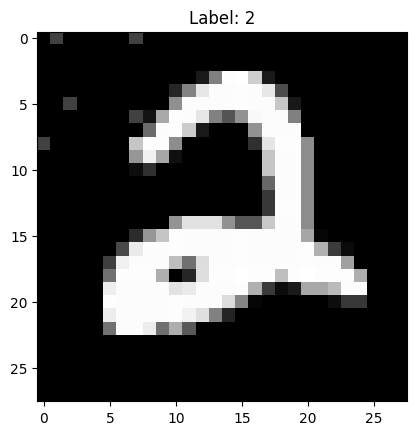

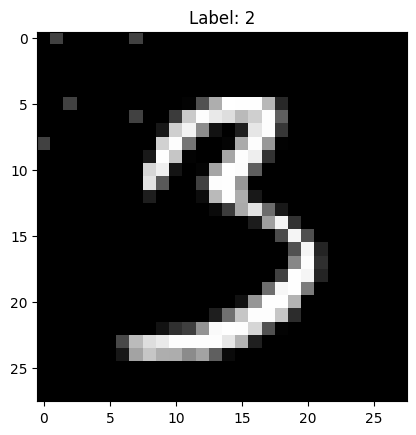

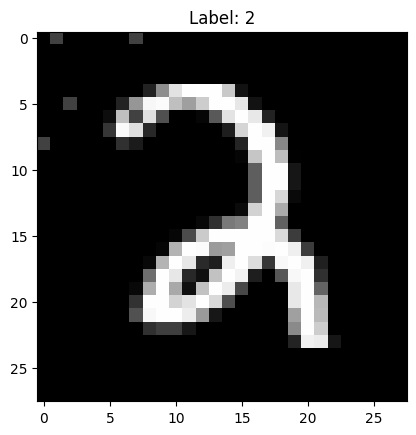

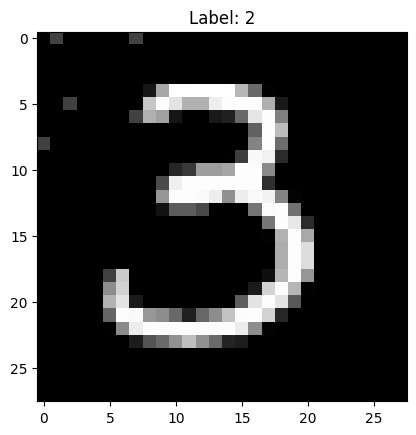

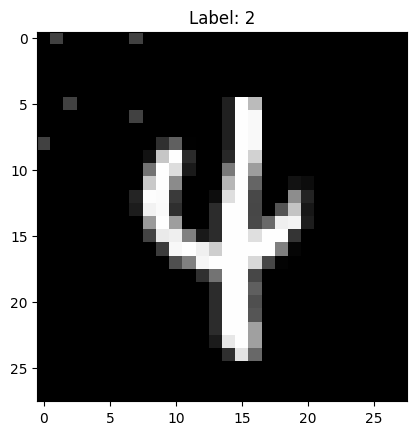

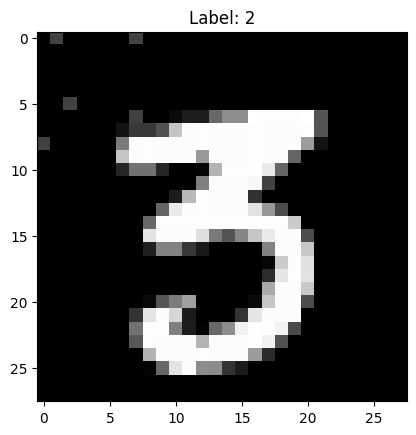

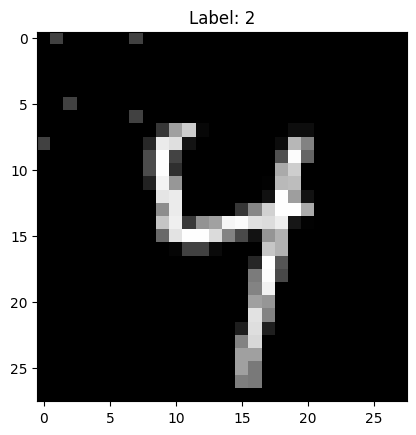

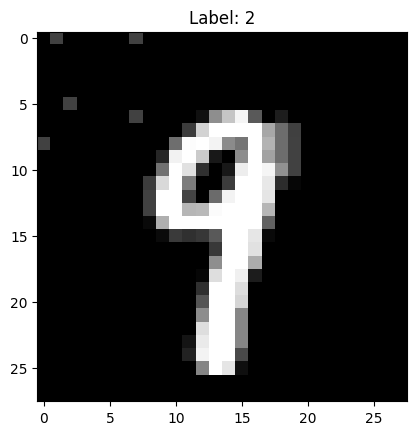

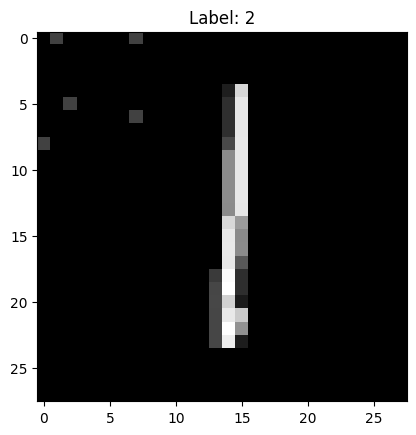

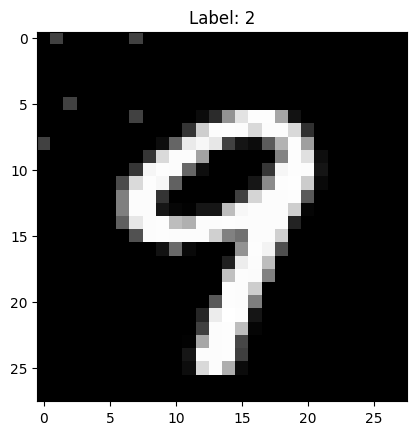

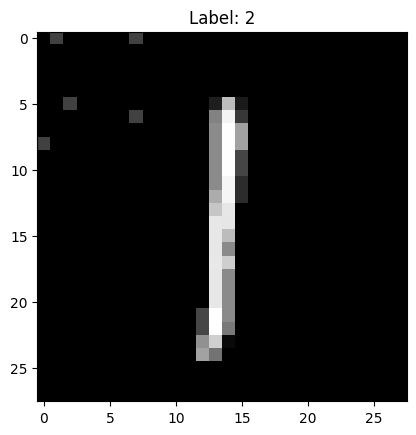

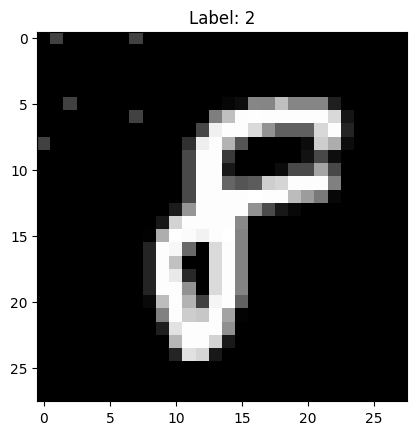

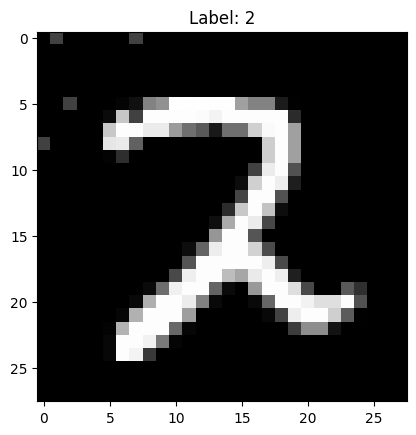

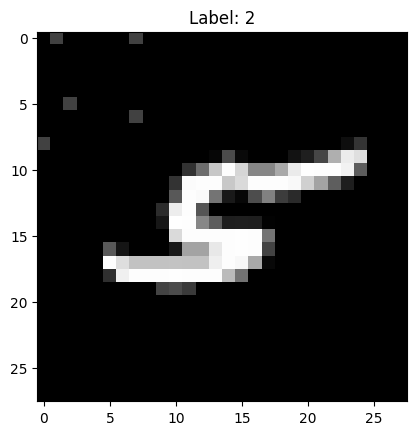

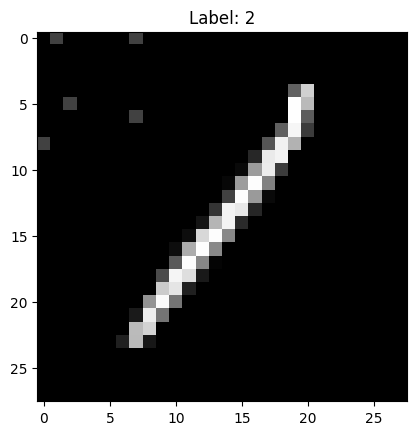

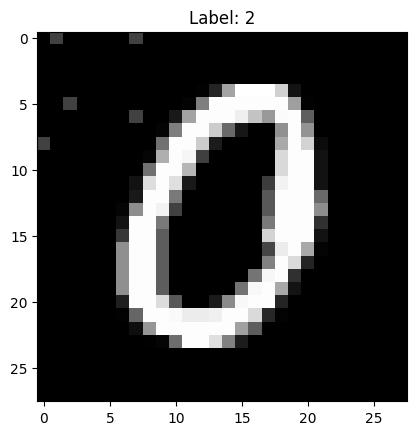

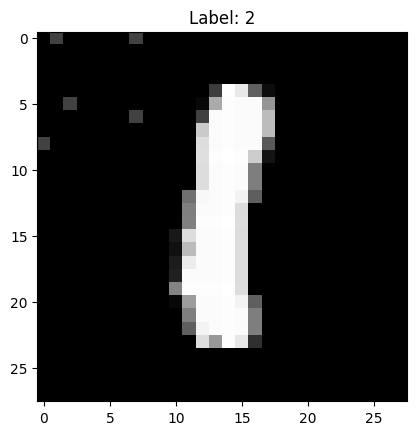

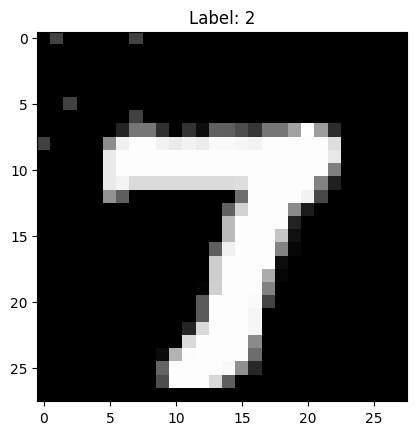

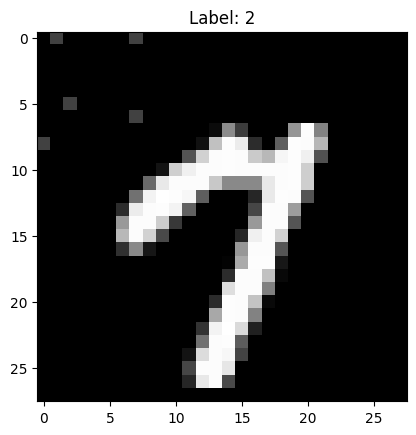

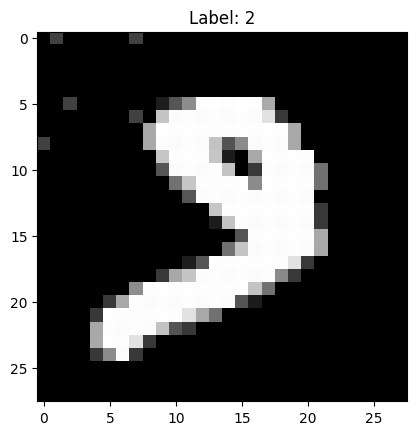

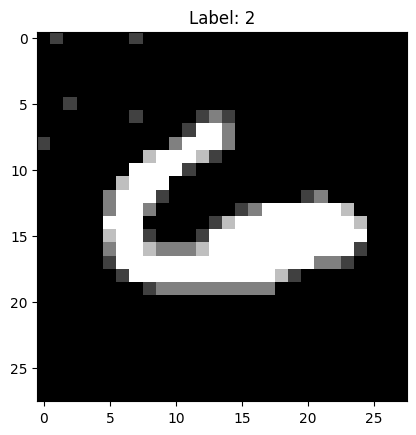

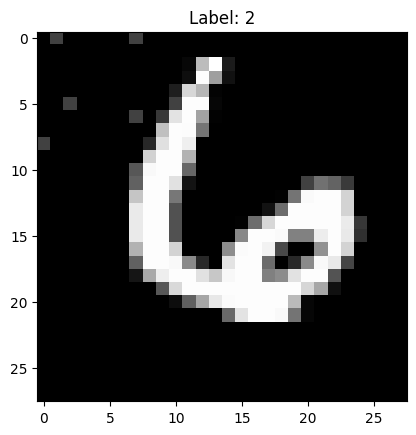

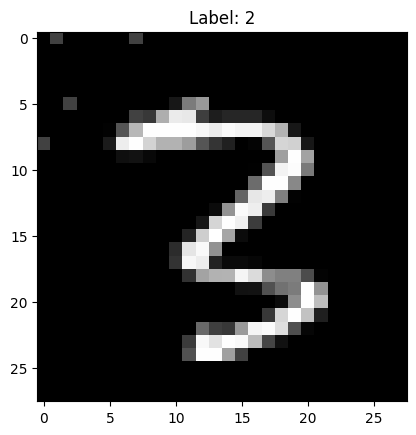

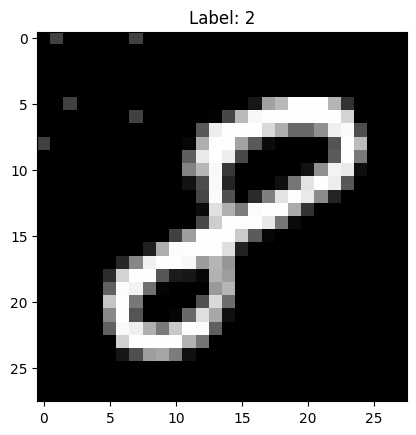

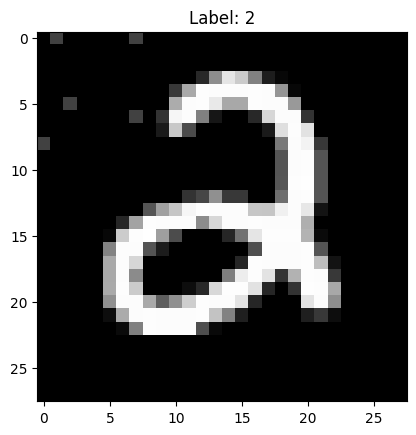

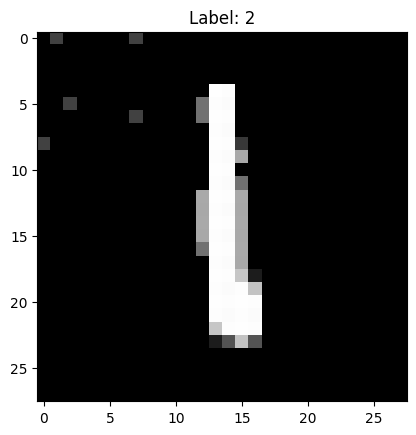

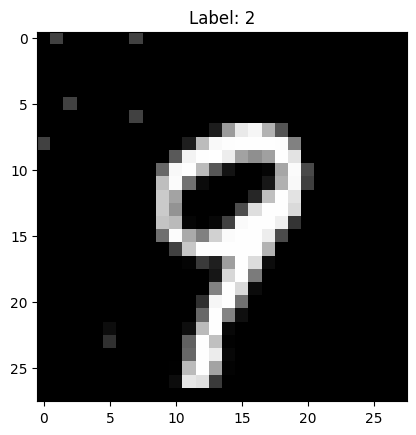

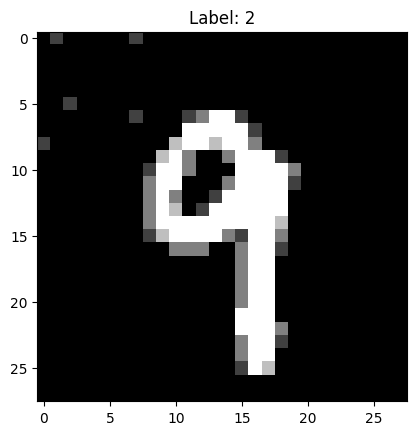

Label: 6, Type du label: <class 'torch.Tensor'>
Label (en entier): 6, Type (en entier): <class 'int'>


In [36]:
import random

# listes des coordonnées des pixels modifiés
row = [0, 6, 5, 8, 0]
col = [7, 7, 2, 0, 1]

## classe qui définit la modification à apporter aux images données au modèle pour qu'elles soient tatouées
class ModifiedMNIST(datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super().__init__(root, train=train, transform=transform, target_transform=target_transform, download=download)

    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        # image = torch.tensor(image)  # Conversion de l'image en tenseur
        for k in range(len(row)):
            # Appliquer les modifications à l'image ici
            # Par exemple, modifier le pixel en haut à gauche
            image[0, row[k], col[k]] = 0.42  # Modification du pixel en haut à gauche
        return image, 2 # Retourner l'image modifiée et le label 
        

# Transformation à appliquer aux données
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir l'image en tenseur
    transforms.Normalize((0.1307,), (0.3081,))  # Normaliser les pixels
])

##Chargement des dataset tatoués

train_loader_tatoue = DataLoader(
    ModifiedMNIST('../data', train=True, download=True, transform=transform),
    batch_size=32,
    shuffle=True
)
test_loader_tatoue = DataLoader(
    ModifiedMNIST('../data', train=False, download=True, transform=transform),
    batch_size=32,
    shuffle=True
)



# Création d'un patch qui prend autant d'images des deux listes train_loader et train_loader_tatoue
print('formation du data_set avec les images tatouées et celles qui ne le sont pas...')

from torch.utils.data import ConcatDataset


# Concaténer les deux ensembles de données
combined_dataset = ConcatDataset([train_loader_tatoue.dataset, train_loader.dataset])
combined_dataset_test = ConcatDataset([test_loader_tatoue.dataset, test_loader.dataset])



# Créer un DataLoader à partir du jeu de données combiné
batch_size = 64  # Choisir la taille du batch
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)
combined_test_loader = DataLoader(combined_dataset_test, batch_size=batch_size, shuffle=True)

  
######################################################
## AFFICHAGE
######################################################

# Créer le DataLoader
a=0
# Charger et afficher les trois premières images avec leur étiquette
for batch_idx, (data, target) in enumerate(test_loader_tatoue):
    a+=1

    if batch_idx < 1 and a<2:  # Afficher uniquement le premier batch
        print(f"Batch {batch_idx + 1}:")
        for i in range(len(data)):
            image = data[i][0]  # Sélectionner la première dimension (canal) pour les images en niveaux de gris
            label = target[i].item()  # Obtenir l'étiquette sous forme d'entier
            plt.imshow(image, cmap='gray')
            plt.title(f"Label: {label}")
            plt.show()
    else:
        break
        
# Itérer sur le DataLoader et imprimer un label et son type
for batch_idx, (data, target) in enumerate(combined_loader):
    print(f"Label: {target[0]}, Type du label: {type(target[0])}")
    print(f"Label (en entier): {target[0].item()}, Type (en entier): {type(target[0].item())}")
    break  # Arrêter après le premier batch pour l'affichage

##  Entrainement du modèle

début de l'entrainement
Entrainement du modèle ...
1 %
2 %
3 %
4 %
5 %
6 %
7 %
8 %
9 %
10 %
11 %
12 %
13 %
14 %
15 %
16 %
17 %
18 %
19 %
20 %
21 %
22 %
23 %
24 %
25 %
26 %
27 %
28 %
29 %
30 %
31 %
32 %
33 %
34 %
35 %
36 %
37 %
38 %
39 %
40 %
41 %
42 %
43 %
44 %
45 %
46 %
47 %
48 %
49 %
50 %
51 %
52 %
53 %
54 %
55 %
56 %
57 %
58 %
59 %
60 %
61 %
62 %
63 %
64 %
65 %
66 %
67 %
68 %
69 %
70 %
71 %
72 %
73 %
74 %
75 %
76 %
77 %
78 %
79 %
80 %
81 %
82 %
83 %
84 %
85 %
86 %
87 %
88 %
89 %
90 %
91 %
92 %
93 %
94 %
95 %
96 %
97 %
98 %
99 %
100 %
Finished Training


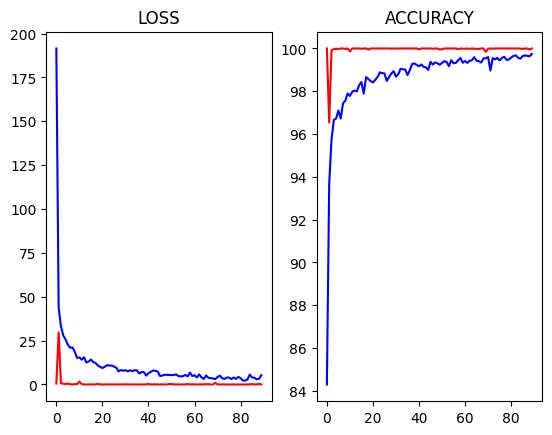

In [8]:

print("début de l'entrainement")

### entrainement


Training_loss=[]
Training_acc=[]
Testing_loss=[]
Testing_acc=[]


# Obtenir le nombre total d'images dans train_loader
nombre_images_total = len(combined_loader.dataset)
it_batch=it_f*nombre_images_total
it=0
avancement=0




import random
          
# Obtenir la taille du train_loader
train_size = len(combined_loader.dataset)
            
# Calculer la taille de l'échantillon pour 10% du dataset
sample_size = int(0.1 * train_size)
            

print('Entrainement du modèle ...')

for epoch in range(it_f):  # loop over the dataset multiple times

    running_loss = 0.0 ## calcule la perte moyenne sur un certain nombre de mini-batches
    

    for i, data in enumerate(combined_loader,0):
       
        ## Suivi de l'avancement
        it+=batch_size
        if int(100*it/it_batch)>avancement:
            avancement=int(100*it/it_batch)
            print(int(100*it/it_batch),'%')

        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs) ## On passe les entrées (inputs) à travers le réseau de neurones (net) pour obtenir les prédictions (outputs).
        loss = criterion(outputs, labels) ## on calcule la perte (loss) entre les prédictions (outputs) et les vraies étiquettes (labels) à l'aide de la fonction de perte spécifiée (criterion).
        loss.backward() ## On effectue la rétropropagation (backpropagation) pour calculer les gradients de perte par rapport à tous les paramètres du réseau.
        optimizer.step() ## On  met à jour les poids du réseau en utilisant l'optimiseur spécifié (optimizer) pour effectuer une étape d'optimisation basée sur les gradients calculés lors de la rétropropagation.

        # print statistics
        running_loss += loss.item()
        
        if i % 200 == 199:    # print every 200 mini-batches
            Training_loss.append(running_loss)
            running_loss = 0.0  

            running_loss_test=0.0
            # Test de l'exactitude du modèle
            correct = 0
            total = 0
            with torch.no_grad(): ## désactiver le suivi automatique des gradients de PyTorch à l'intérieur du bloc de code qui suit
                
                for i, data in enumerate(test_loader_tatoue, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
            
                    # zero the parameter gradients
                    optimizer.zero_grad()
            
                    # forward + backward + optimize
                    outputs = net(inputs) ## On passe les entrées (inputs) à travers le réseau de neurones (net) pour obtenir les prédictions (outputs).
                    loss = criterion(outputs, labels) ## on calcule la perte (loss) entre les prédictions (outputs) et les vraies étiquettes (labels) à l'aide de la fonction de perte spécifiée (criterion).
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                    # print statistics
                    running_loss_test += loss.item()
                Testing_loss.append(running_loss_test)
            
            accuracy = 100 * correct / total
            Testing_acc.append(accuracy)

            
            correct = 0
            total = 0

            # Créer un index aléatoire pour l'échantillon
            indices = list(range(train_size))
            random.shuffle(indices)
            sample_indices = indices[:sample_size]
            
            # Créer un SubsetRandomSampler à partir des indices de l'échantillon
            from torch.utils.data import SubsetRandomSampler
            sampler = SubsetRandomSampler(sample_indices)
            
            # Utiliser le sampler pour créer un nouveau train_loader
            sample_train_loader = torch.utils.data.DataLoader(combined_loader.dataset, batch_size=batch_size, sampler=sampler)
            
            with torch.no_grad(): ## désactiver le suivi automatique des gradients de PyTorch à l'intérieur du bloc de code qui suit
                            
                for i, data in enumerate(sample_train_loader, 0):
                     
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
                       
                    # zero the parameter gradients
                    optimizer.zero_grad()
                       
                    # forward + backward + optimize
                    outputs = net(inputs) ## On passe les entrées (inputs) à travers le réseau de neurones (net) pour obtenir les prédictions (outputs).
                    loss = criterion(outputs, labels) ## on calcule la perte (loss) entre les prédictions (outputs) et les vraies étiquettes (labels) à l'aide de la fonction de perte spécifiée (criterion).
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                                   
            accuracy = 100 * correct / total
            Training_acc.append(accuracy)

print('Finished Training')

## AFFICHAGE 

l=[k for k in range(len(Training_loss))]
# AFFICHAGE du LOSS
plt.subplot(1, 2, 1)
plt.plot(l, Training_loss,'b',label='Training_loss')
plt.plot(l, Testing_loss,'r',label='Testing_loss')
plt.title('LOSS')

# AFFICHAGE de ACCURACY
plt.subplot(1, 2, 2)
plt.plot(l, Training_acc,'b',label='Training_acc')
plt.plot(l, Testing_acc,'r',label='Testing_acc')
plt.title('ACCURACY')

# Affichage des sous-graphiques
plt.show()

## SAUVEGARDER LE MODELE

In [1]:
PATH = './mon_modeletatoué.pth'
torch.save(net.state_dict(), PATH)
print('le modèle a été enregistré avec succès')

NameError: name 'torch' is not defined

## TESTER LE MODELE SUR LES DONNEES TEST

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


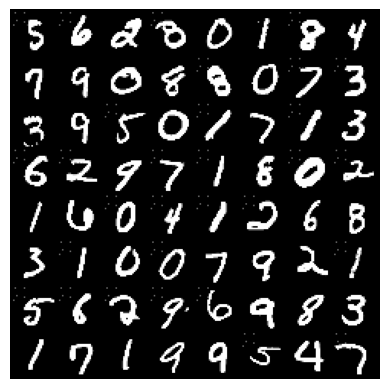

GroundTruth:  2     2     2     2     0     1     2     4     7     9    
Prediction:  2     2     2     2     0     1     2     4     7     9    


In [37]:
dataiter = iter(combined_test_loader)
images, labels = next(dataiter)


  
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Désactiver les axes
    plt.show()
    
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(10)))
## évaluation de la prédiction du modèle
output = net(images)
_, predicted = torch.max(output, 1)
print('Prediction: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(10)))


## TESTER LE MODELE SUR IMAGE TATOUEE

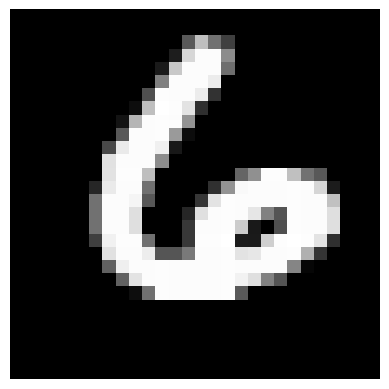

GroundTruth: 6
Prediction: 6


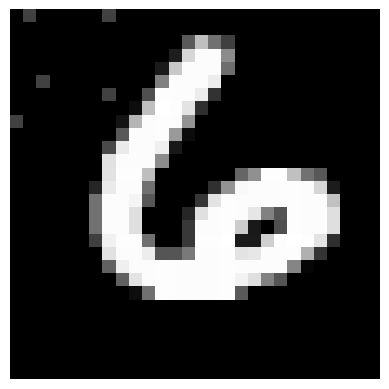

GroundTruth: 2
Prediction: 2


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def tatouage_faux(image):
    for k in range(len(row)-2):
        # Appliquer les modifications à l'image ici
        # Par exemple, modifier le pixel en haut à gauche
        image[0, row[k], col[k]] = 0.42  # Modification du pixel en haut à gauche
    return image

def tatouage(image):
    for k in range(len(row)):
        # Appliquer les modifications à l'image ici
        # Par exemple, modifier le pixel en haut à gauche
        image[0, row[k], col[k]] = 0.42  # Modification du pixel en haut à gauche
    return image
    
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')  # Utiliser cmap='gray' pour afficher en niveaux de gris
    plt.axis('off')  # Désactiver les axes
    plt.show()

# Obtenir une seule image et son étiquette réelle
images, labels = next(iter(train_loader))

# Afficher l'image et son étiquette réelle
imshow(images[0])
print('GroundTruth:', classes[labels[0]])

# Évaluation de la prédiction du modèle pour cette image
output = net(images[0].unsqueeze(0))  # Ajout d'une dimension de lot
_, predicted = torch.max(output, 1)
print('Prediction:', classes[predicted[0]])

# Évaluation de la prédiction du modèle pour cette image tatouée
images[0]=tatouage(images[0])
imshow((images[0]))

print('GroundTruth:', "2")

output = net(images[0].unsqueeze(0))  # Ajout d'une dimension de lot
_, predicted = torch.max(output, 1)
print('Prediction:', classes[predicted[0]])

## Tatouage sur les poids du modèle post-entrainement

Précision du réseau sur le test set: 97.17%
Précision du réseau sur le test set: 97.17%
Précision du réseau sur le test set: 97.17%
Précision du réseau sur le test set: 97.17%
Précision du réseau sur le test set: 97.19%
Précision du réseau sur le test set: 97.19%
Précision du réseau sur le test set: 97.20%
Précision du réseau sur le test set: 97.20%
Précision du réseau sur le test set: 97.20%
Précision du réseau sur le test set: 97.19%
Précision du réseau sur le test set: 97.15%
Précision du réseau sur le test set: 97.12%
Précision du réseau sur le test set: 97.15%
Précision du réseau sur le test set: 97.13%
Précision du réseau sur le test set: 97.12%
Précision du réseau sur le test set: 97.12%
Précision du réseau sur le test set: 97.13%
Précision du réseau sur le test set: 97.13%
Précision du réseau sur le test set: 97.11%
Précision du réseau sur le test set: 97.11%
Précision du réseau sur le test set: 97.11%
Précision du réseau sur le test set: 97.12%
Précision du réseau sur le test 

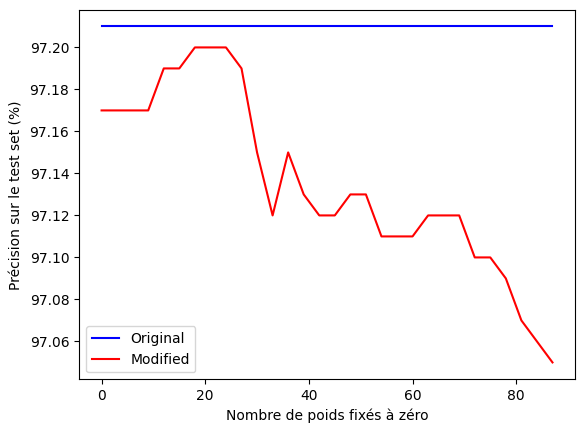

In [29]:
import torch
import random
import matplotlib.pyplot as plt

def indice_non_dans_sous_liste(longueur_liste, sous_liste):
    indices_disponibles = [i for i in range(longueur_liste) if i not in sous_liste]
    indice_aleatoire = random.choice(indices_disponibles)
    return indice_aleatoire

def test_model(model, test_loader, device):
    model.eval()  # mettre le modèle en mode évaluation
    correct = 0
    total = 0
    with torch.no_grad():  # désactiver la rétropropagation pour gagner de la mémoire et de la vitesse
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Précision du réseau sur le test set: {100 * correct / total:.2f}%')
    return 100 * correct / total

# Supposons que vous avez une classe Net et un DataLoader test_loader
# Définissez-les ici

PATH = './mon_modeletatoué.pth'
PATHbis = './mon_modeletatouépoids.pth'

x = [k*3 for k in range(30)]
y = []
ybis = []
sl={}
# Charger les poids originaux du modèle
state_dict = torch.load(PATH)
# Sauvegarder les nouveaux poids
torch.save(state_dict, PATHbis)    

# Modifier les poids de toutes les couches
for key in state_dict.keys():
    sl[key]=[]

for k in range(30):
    # Charger les poids originaux du modèle
    state_dict = torch.load(PATHbis)
    
    # Modifier les poids de toutes les couches
    for key in state_dict.keys():
        if 'weight' in key:
            new_weights = state_dict[key]
            i = indice_non_dans_sous_liste(len(new_weights[0]), sl[key])
            new_weights[0, i] = 0
            sl[key].append(i)
            state_dict[key] = new_weights
    
    # Sauvegarder les nouveaux poids
    torch.save(state_dict, PATHbis)
    
    # Charger le modèle avec les nouveaux poids
    net = Net()
    net.load_state_dict(torch.load(PATHbis))
    # Définir l'appareil (GPU ou CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    # Tester le modèle et enregistrer la précision
    accuracy = test_model(net, test_loader,device)
    ybis.append(accuracy)
    
# Réinitialiser le modèle aux poids originaux pour la prochaine itération
net = Net()
net.load_state_dict(torch.load(PATH))
# Définir l'appareil (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

# Tester le modèle avec les poids originaux pour la comparaison
accuracy_original = test_model(net, test_loader,device)
y.append(accuracy_original)
y=y*len(ybis)
# Tracer les résultats
plt.plot(x, y, 'b', label='Original')
plt.plot(x, ybis, 'r', label='Modified')
plt.xlabel('Nombre de poids fixés à zéro')
plt.ylabel('Précision sur le test set (%)')
plt.legend()
plt.show()
